# COVID Parcel Business Analysis

### Objective
Analyze weekly parcel data from 2019–2020, cleaned and enriched with:
- CustomerGroup and YearWeek
- Parcel volume trends (Pre-COVID vs COVID)
- Customer classification
- Revenue estimation
- Visualizations and export summary

In [2]:

import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("COVID_Parcel_Business.csv")
df.head()


,FakeCustomerID,THE_YEAR,THE_WEEK,VOLUME
0,718117,2021,1,8
1,718117,2020,7,257
2,718117,2019,39,141
3,718117,2018,1,14
4,718117,2021,2,192


In [3]:

# Rename for consistency
df.rename(columns={
    "FakeCustomerID": "CustomerID",
    "THE_YEAR": "Year",
    "THE_WEEK": "Week",
    "VOLUME": "Parcels"
}, inplace=True)

# Add CustomerGroup based on ID hash
group_labels = ['Enterprise', 'Large', 'Medium', 'Small']
df['CustomerGroup'] = df['CustomerID'].apply(lambda x: group_labels[x % 4])

# Add YearWeek
df['YearWeek'] = df['Year'].astype(str) + '-W' + df['Week'].astype(str).str.zfill(2)

# Filter for analysis years only
df = df[df["Year"].isin([2019, 2020])]
df.head()


,CustomerID,Year,Week,Parcels,CustomerGroup,YearWeek
1,718117,2020,7,257,Large,2020-W07
2,718117,2019,39,141,Large,2019-W39
6,718117,2020,8,232,Large,2020-W08
7,718117,2020,10,229,Large,2020-W10
8,718117,2020,2,251,Large,2020-W02


In [4]:

pre_covid_weeks = list(range(1, 16))
covid_weeks = list(range(16, 54))

vol_2019_pre = df[(df["Year"] == 2019) & (df["Week"].isin(pre_covid_weeks))].groupby(["CustomerID", "CustomerGroup"])["Parcels"].sum().rename("Vol_2019_Pre")
vol_2020_pre = df[(df["Year"] == 2020) & (df["Week"].isin(pre_covid_weeks))].groupby(["CustomerID", "CustomerGroup"])["Parcels"].sum().rename("Vol_2020_Pre")
vol_2020_covid = df[(df["Year"] == 2020) & (df["Week"].isin(covid_weeks))].groupby(["CustomerID", "CustomerGroup"])["Parcels"].sum().rename("Vol_2020_COVID")

df_vol = pd.concat([vol_2019_pre, vol_2020_pre, vol_2020_covid], axis=1).fillna(0).reset_index()

total_2019_pre = df_vol["Vol_2019_Pre"].sum()
total_2020_pre = df_vol["Vol_2020_Pre"].sum()
ISGR = round(((total_2020_pre - total_2019_pre) / total_2019_pre) * 100, 2)
print("ISGR =", ISGR)


ISGR = 11.4


In [5]:

def classify(row):
    if row['Vol_2019_Pre'] == 0 and row['Vol_2020_Pre'] == 0 and row['Vol_2020_COVID'] > 0:
        return 'New'
    elif row['Vol_2020_COVID'] == 0 and (row['Vol_2019_Pre'] > 0 or row['Vol_2020_Pre'] > 0):
        return 'Lost'
    elif row['Vol_2020_Pre'] == 0:
        return 'New' if row['Vol_2020_COVID'] > 0 else 'Lost'
    else:
        growth = ((row['Vol_2020_COVID'] - row['Vol_2020_Pre']) / row['Vol_2020_Pre']) * 100
        if growth > ISGR:
            return 'High Growth'
        elif 0 <= growth <= ISGR:
            return 'Stable'
        else:
            return 'Declining'

df_vol["CustomerStatus"] = df_vol.apply(classify, axis=1)
df_vol["Estimated_Revenue_COVID"] = df_vol["Vol_2020_COVID"] * 22
df_vol["CustomerStatus"].value_counts()


,count
CustomerStatus,
High Growth,941
Declining,73
Lost,28
Stable,10
New,7


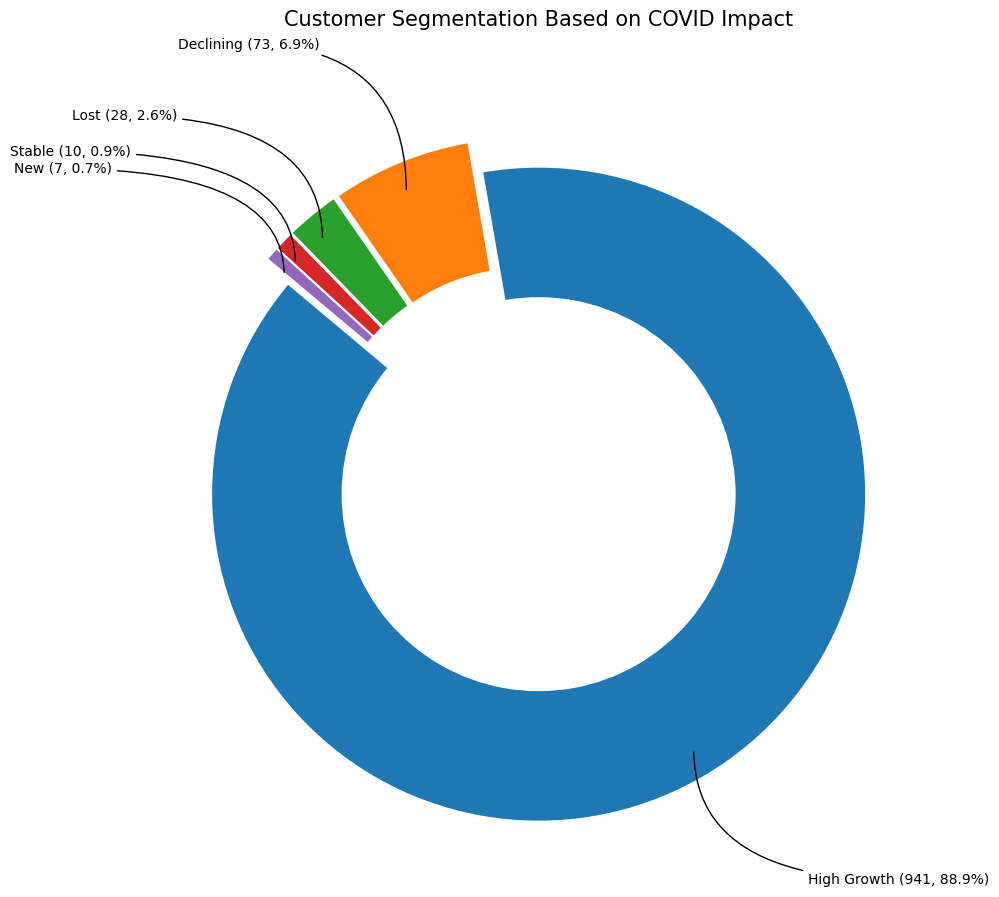

In [6]:

import matplotlib.pyplot as plt
import numpy as np

# Count how many customers fall into each status category
status_counts = df_vol["CustomerStatus"].value_counts()

# Create labels with name, count, and percentage
labels = [
    f"{status} ({count}, {count / sum(status_counts) * 100:.1f}%)"
    for status, count in zip(status_counts.index, status_counts)
]

fig, ax = plt.subplots(figsize=(10, 9))
wedges, texts = ax.pie(
    status_counts,
    startangle=140,
    explode=[0.05] * len(labels),
    wedgeprops=dict(width=0.4, edgecolor='w')
)

# Add arrows and labels that point lower and stay clear of title
for i, wedge in enumerate(wedges):
    angle = (wedge.theta2 + wedge.theta1) / 2
    x = np.cos(np.radians(angle))
    y = np.sin(np.radians(angle)) * 0.95

    ax.annotate(
        labels[i],
        xy=(x, y),
        xytext=(1.7 * x, 1.5 * y),
        ha='left' if x >= 0 else 'right',
        arrowprops=dict(arrowstyle="-", connectionstyle="angle3,angleA=0,angleB=90"),
        fontsize=10
    )

plt.title("Customer Segmentation Based on COVID Impact", fontsize=15, y=1.1)
plt.axis('equal')
plt.tight_layout()
plt.show()


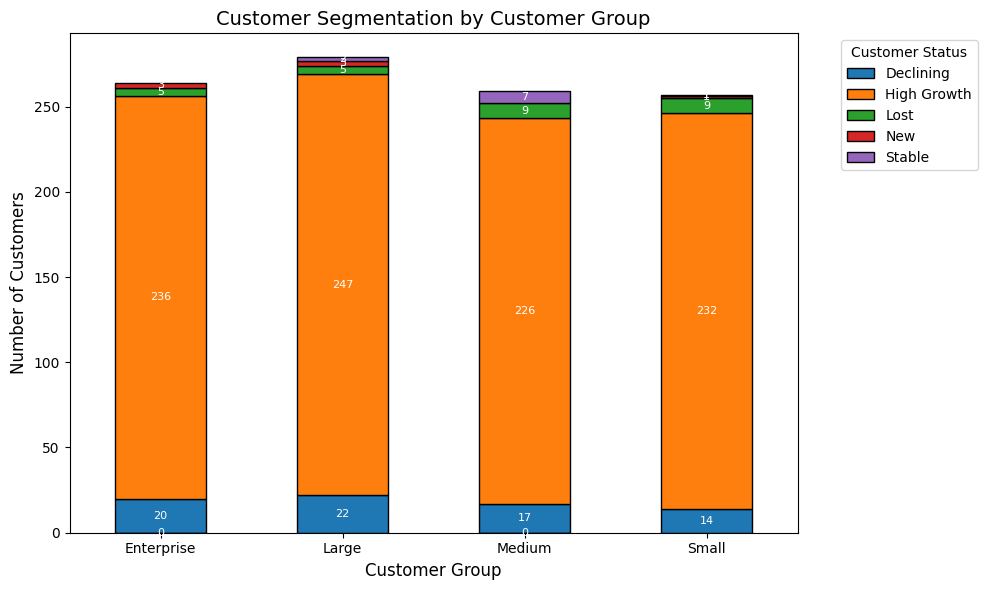

In [7]:
import matplotlib.pyplot as plt

# Prepare the grouped summary data
group_summary = df_vol.groupby(["CustomerGroup", "CustomerStatus"]).size().unstack(fill_value=0)

color_map = {
    'Declining': '#1f77b4',  # Blue
    'High Growth': '#ff7f0e',  # Orange
    'Lost': '#2ca02c',  # Green
    'New': '#d62728',  # Red
    'Stable': '#9467bd'  # Purple
}

colors = [color_map[col] for col in group_summary.columns]

ax = group_summary.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6),
    color=colors,
    edgecolor='black'
)

for container in ax.containers:
    ax.bar_label(container, label_type='center', fontsize=8, color='white')

plt.title("Customer Segmentation by Customer Group", fontsize=14)
plt.xlabel("Customer Group", fontsize=12)
plt.ylabel("Number of Customers", fontsize=12)
plt.xticks(rotation=0)
plt.legend(title="Customer Status", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


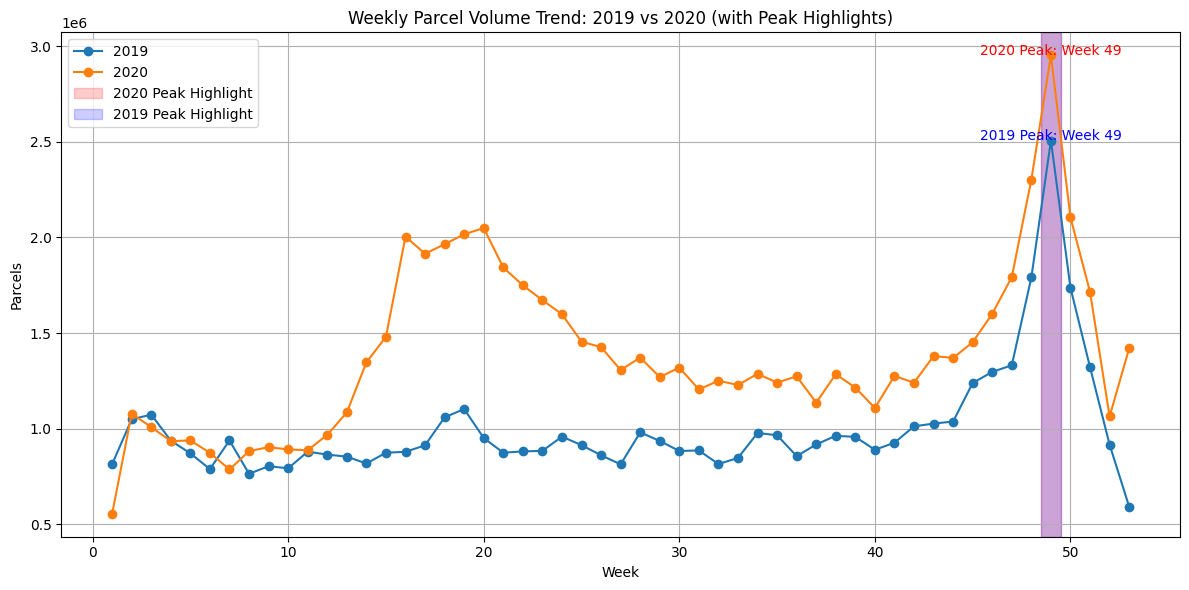

In [8]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


weekly_trend = df.groupby(["Year", "Week"])["Parcels"].sum().reset_index()

# Identify peak weeks
peak_2020 = weekly_trend[weekly_trend["Year"] == 2020].sort_values("Parcels", ascending=False).iloc[0]
peak_2019 = weekly_trend[weekly_trend["Year"] == 2019].sort_values("Parcels", ascending=False).iloc[0]

# Plot with highlighted rectangles
plt.figure(figsize=(12, 6))

for year in [2019, 2020]:
    data = weekly_trend[weekly_trend["Year"] == year]
    plt.plot(data["Week"], data["Parcels"], marker='o', label=str(year))

# Highlight peak week with rectangle (2020)
plt.axvspan(peak_2020["Week"] - 0.5, peak_2020["Week"] + 0.5,
            color='red', alpha=0.2, label='2020 Peak Highlight')
plt.text(peak_2020["Week"], peak_2020["Parcels"] + 2500,
         f'2020 Peak: Week {int(peak_2020["Week"])}',
         color='red', ha='center')

# Highlight peak week with rectangle (2019)
plt.axvspan(peak_2019["Week"] - 0.5, peak_2019["Week"] + 0.5,
            color='blue', alpha=0.2, label='2019 Peak Highlight')
plt.text(peak_2019["Week"], peak_2019["Parcels"] + 2500,
         f'2019 Peak: Week {int(peak_2019["Week"])}',
         color='blue', ha='center')

plt.title("Weekly Parcel Volume Trend: 2019 vs 2020 (with Peak Highlights)")
plt.xlabel("Week")
plt.ylabel("Parcels")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:

df_export = df_vol[[
    "CustomerID", "CustomerGroup", "Vol_2019_Pre", "Vol_2020_Pre", "Vol_2020_COVID",
    "CustomerStatus", "Estimated_Revenue_COVID"
]]
df_export.to_excel("COVID_Parcel_Final_Summary.xlsx", index=False)
df_export.head()


,CustomerID,CustomerGroup,Vol_2019_Pre,Vol_2020_Pre,Vol_2020_COVID,CustomerStatus,Estimated_Revenue_COVID
0,100771,Small,442.0,448.0,1341.0,High Growth,29502.0
1,102180,Enterprise,1365.0,828.0,3989.0,High Growth,87758.0
2,102643,Small,745.0,599.0,1104.0,High Growth,24288.0
3,102750,Medium,344.0,196.0,209.0,Stable,4598.0
4,103308,Enterprise,19560.0,23748.0,79952.0,High Growth,1758944.0
